In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parameters
mu = 1e2  # Default mu value
Tmax = 200
h = 1e-3  # Step size
Nsteps = int(Tmax / h)

# Initial conditions
y0 = np.array([2.0, 0.0])  # (x, y)

# Define the system of equations
def func(y, mu):
    x, v = y
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])

# Jacobian matrix for Newton's iteration
def Jac(y, mu):
    x, v = y
    J = np.array([
        [0, 1],
        [-2 * mu * x * v - 1, mu * (1 - x**2)]
    ])
    return J


In [2]:
def NewtonIterDIRK2(y, h, k, gamma, mu):
    """
    Newton iteration to solve for the implicit Runge-Kutta stages.
    """
    aux = y + h * gamma * k
    F = k - func(aux, mu)
    DF = np.identity(2) - h * gamma * Jac(aux, mu)
    return k - np.linalg.solve(DF, F)

def DIRK2step(y, h, mu):
    """
    Performs a single DIRK2 step.
    """
    gamma = 1.0 - 1.0 / np.sqrt(2)
    k1 = func(y, mu)

    for _ in range(20):
        k1_new = NewtonIterDIRK2(y, h, k1, gamma, mu)
        if np.linalg.norm(k1_new - k1) < 1e-14:
            break
        k1 = k1_new

    k2 = func(y + h * (1 - 2 * gamma) * k1, mu)

    for _ in range(20):
        k2_new = NewtonIterDIRK2(y + h * (1 - 2 * gamma) * k1, h, k2, gamma, mu)
        if np.linalg.norm(k2_new - k2) < 1e-14:
            break
        k2 = k2_new

    return y + h * (0.5 * k1 + 0.5 * k2)


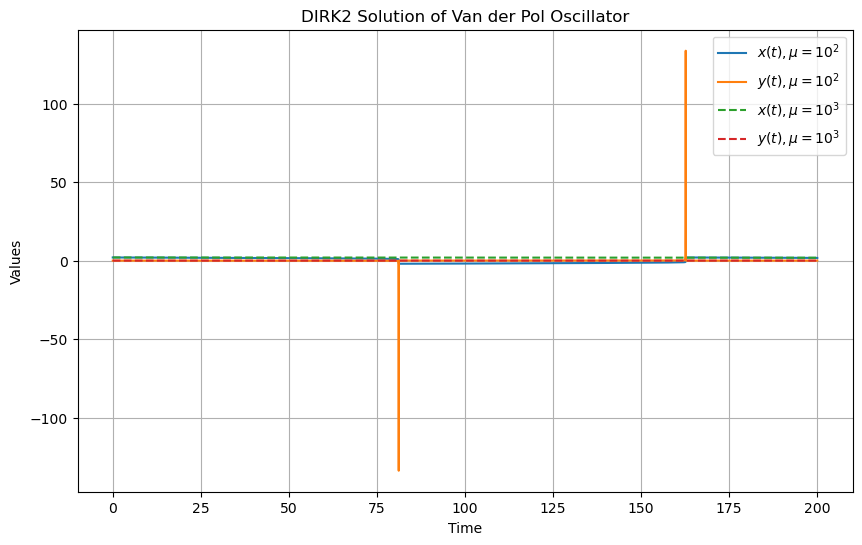

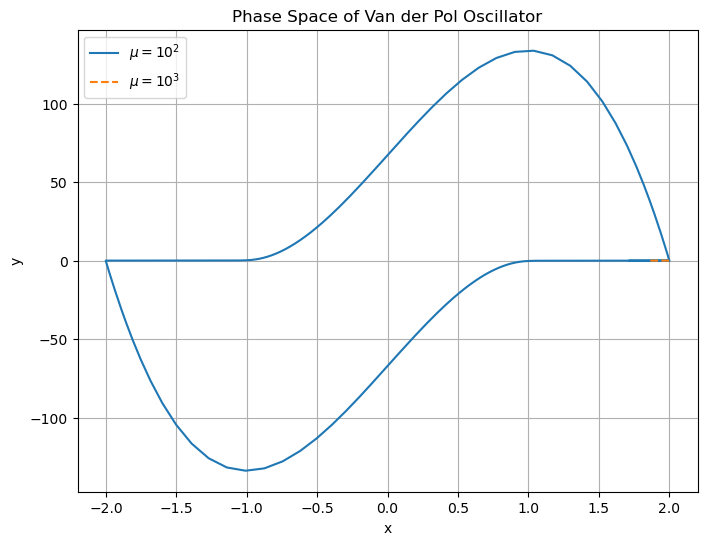

CPU time for mu=1e2: 6.7722 seconds
CPU time for mu=1e3: 6.6830 seconds


In [3]:
def solve_van_der_pol(mu, h, Tmax):
    """
    Solves the Van der Pol oscillator using DIRK2.
    """
    Nsteps = int(Tmax / h)
    sol = np.zeros((Nsteps + 1, 2))
    t = np.linspace(0, Tmax, Nsteps + 1)
    sol[0, :] = y0

    start_time = time.time()

    for j in range(Nsteps):
        sol[j + 1, :] = DIRK2step(sol[j, :], h, mu)

    end_time = time.time()
    t_cpu = end_time - start_time

    return t, sol, t_cpu

# Solve for mu = 1e2 and mu = 1e3
t1, sol1, cpu1 = solve_van_der_pol(1e2, h, Tmax)
t2, sol2, cpu2 = solve_van_der_pol(1e3, h, Tmax)

# Plot x and y vs time
plt.figure(figsize=(10, 6))
plt.plot(t1, sol1[:, 0], label=r'$x(t), \mu=10^2$')
plt.plot(t1, sol1[:, 1], label=r'$y(t), \mu=10^2$')
plt.plot(t2, sol2[:, 0], label=r'$x(t), \mu=10^3$', linestyle='dashed')
plt.plot(t2, sol2[:, 1], label=r'$y(t), \mu=10^3$', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('DIRK2 Solution of Van der Pol Oscillator')
plt.grid()
plt.show()

# Phase plot
plt.figure(figsize=(8, 6))
plt.plot(sol1[:, 0], sol1[:, 1], label=r'$\mu=10^2$')
plt.plot(sol2[:, 0], sol2[:, 1], label=r'$\mu=10^3$', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Phase Space of Van der Pol Oscillator')
plt.grid()
plt.show()

print(f'CPU time for mu=1e2: {cpu1:.4f} seconds')
print(f'CPU time for mu=1e3: {cpu2:.4f} seconds')


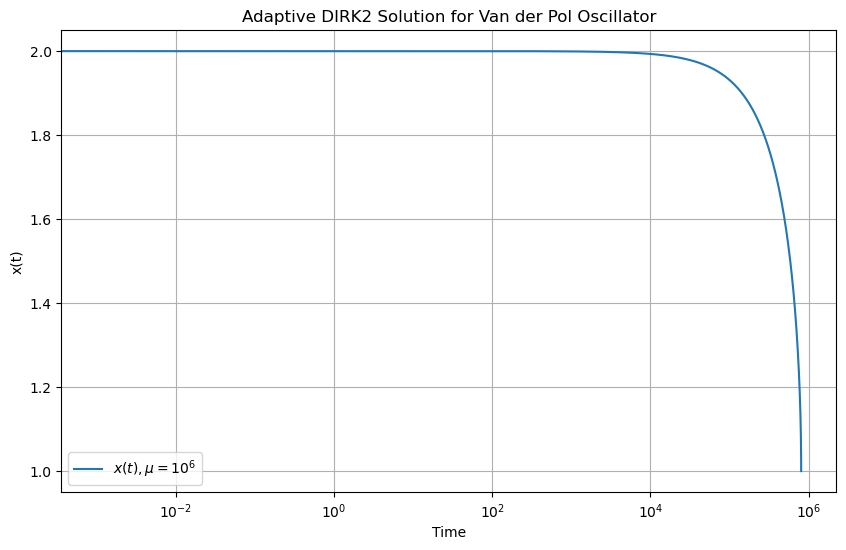

CPU time for adaptive solver with mu=1e6: 2.8729 seconds


In [5]:
def adaptive_solver(mu, Tmax):
    atol = 1e-5
    rtol = 1e-5
    h = 1e-3  # Initial step size
    t = [0]
    sol = [y0]
    cpu_start = time.time()

    while t[-1] < Tmax:
        y_new = DIRK2step(sol[-1], h, mu)
        e = np.linalg.norm(y_new - sol[-1])

        # Adaptive step size
        if e < atol + rtol * np.linalg.norm(y_new):
            sol.append(y_new)
            t.append(t[-1] + h)
            h *= 1.2  # Increase step size
        else:
            h *= 0.5  # Decrease step size

        if h < 1e-6:  # Prevent too small steps
            break

    cpu_end = time.time()

    return np.array(t), np.array(sol), cpu_end - cpu_start

t_adaptive, sol_adaptive, cpu_adaptive = adaptive_solver(1e6, 2e6)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t_adaptive, sol_adaptive[:, 0], label=r'$x(t), \mu=10^6$')
plt.xscale('log')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.title('Adaptive DIRK2 Solution for Van der Pol Oscillator')
plt.grid()
plt.show()

print(f'CPU time for adaptive solver with mu=1e6: {cpu_adaptive:.4f} seconds')
